# nRWPE-diag Discrimination Testing on Graph Expressiveness Benchmark

This notebook demonstrates **nonlinear Random Walk Positional Encoding (nRWPE)** methods for discriminating non-isomorphic graph pairs. It evaluates 7 PE variants on a benchmark of graph pairs across multiple difficulty categories.

**What this does:**
- Computes standard RWPE and several nRWPE variants (tanh, softplus, ReLU, off-diagonal)
- Measures discrimination rates: can the PE distinguish non-isomorphic graphs?
- Verifies equivariance under node permutations
- Analyzes convergence (T=20 vs T=50) and threshold sensitivity
- Compares methods head-to-head

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# numpy, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import json
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter3_nrwpe_diag_disc/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception:
        pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f:
            return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {data['metadata']['total_pairs']} graph pairs")
print(f"Sources: {list(data['metadata']['sources'].keys())}")

Loaded 20 graph pairs
Sources: ['programmatic', 'brec']


## Configuration

Tunable parameters for the experiment.

In [5]:
# --- Config ---
# Using original paper values (fits within runtime budget)
K_RWPE = 20           # RWPE walk length
T_NRWPE = 20          # nRWPE walk steps
T_NRWPE_LONG = 50     # nRWPE long walk

THRESHOLD = 1e-6

N_EQUIV_GRAPHS = 20   # Equivariance test graphs
N_EQUIV_PERMS = 50    # Permutations per graph

HOPS = [1, 2]
MAX_PAIRS = None

## Nonlinearity Functions

Activation functions used in nRWPE.

In [6]:
def tanh_fn(x):
    return np.tanh(x)

def softplus_fn(x):
    return np.log1p(np.exp(np.clip(x, -50, 50)))

def relu_fn(x):
    return np.maximum(0.0, x)

def identity_fn(x):
    return x

## Core PE Computation Functions

- : row-stochastic A_tilde = D^{-1} A
- : diagonal of A_tilde^k
- : X_{t+1} = sigma(A_tilde @ X_t)
- : nRWPE with 1/2-hop neighbor aggregation

In [7]:
def build_normalized_adjacency(adj_matrix):
    A = np.array(adj_matrix, dtype=np.float64)
    D = A.sum(axis=1)
    D_inv = np.zeros_like(D)
    mask = D > 0
    D_inv[mask] = 1.0 / D[mask]
    A_tilde = np.diag(D_inv) @ A
    return A_tilde

def compute_rwpe_diag(A_tilde, K):
    n = A_tilde.shape[0]
    pe = np.zeros((n, K))
    M = A_tilde.copy()
    for k in range(K):
        pe[:, k] = np.diag(M)
        if k < K - 1:
            M = M @ A_tilde
    return pe

def compute_nrwpe_diag(A_tilde, sigma, T):
    n = A_tilde.shape[0]
    pe = np.zeros((n, T))
    X = np.eye(n)
    for t in range(T):
        X = sigma(A_tilde @ X)
        pe[:, t] = np.diag(X)
    return pe

def compute_nrwpe_offdiag(A_tilde, sigma, T, hops=None):
    if hops is None:
        hops = [1, 2]
    n = A_tilde.shape[0]
    A = (np.abs(A_tilde) > 1e-15).astype(float)
    A1 = A.copy()
    A2 = (A @ A > 0).astype(float) - A1 - np.eye(n)
    A2 = np.maximum(A2, 0)
    d1 = A1.sum(axis=1, keepdims=True); d1[d1 == 0] = 1
    A1_norm = A1 / d1
    d2 = A2.sum(axis=1, keepdims=True); d2[d2 == 0] = 1
    A2_norm = A2 / d2
    n_features = 1 + len(hops)
    pe = np.zeros((n, T * n_features))
    X = np.eye(n)
    for t in range(T):
        X = sigma(A_tilde @ X)
        pe[:, t * n_features] = np.diag(X)
        if 1 in hops:
            pe[:, t * n_features + 1] = np.diag(A1_norm @ X)
        if 2 in hops:
            pe[:, t * n_features + 2] = np.diag(A2_norm @ X)
    return pe

## Pair Comparison & Data Parsing

Compare PE multisets via lexicographic sort + L2 distance.

In [8]:
def compare_pair(pe_A, pe_B):
    if pe_A.shape != pe_B.shape:
        return float('inf'), float('inf')
    idx_A = np.lexsort(pe_A.T[::-1])
    idx_B = np.lexsort(pe_B.T[::-1])
    sorted_A = pe_A[idx_A]
    sorted_B = pe_B[idx_B]
    l2_dist = float(np.linalg.norm(sorted_A - sorted_B))
    linf_dist = float(np.max(np.abs(sorted_A - sorted_B)))
    return l2_dist, linf_dist

def parse_pairs(data, max_examples=None):
    examples = data['datasets'][0]['examples']
    if max_examples is not None:
        examples = examples[:max_examples]
    print(f'Parsing {len(examples)} graph pairs...')
    pairs = []
    for ex in examples:
        input_data = json.loads(ex['input'])
        output_data = json.loads(ex['output'])
        pairs.append({
            'adj_A': input_data['graph_A']['adjacency_matrix'],
            'adj_B': input_data['graph_B']['adjacency_matrix'],
            'num_nodes_A': input_data['graph_A']['num_nodes'],
            'num_nodes_B': input_data['graph_B']['num_nodes'],
            'category': ex['metadata_category'],
            'pair_id': ex['metadata_pair_id'],
            'are_cospectral': output_data.get('are_cospectral', False),
        })
    return pairs

pairs = parse_pairs(data, max_examples=MAX_PAIRS)
categories = sorted(set(p['category'] for p in pairs))
cat_counts = {cat: sum(1 for p in pairs if p['category'] == cat) for cat in categories}
print(f'Categories: {cat_counts}')

Parsing 20 graph pairs...
Categories: {'BREC_4Vertex': 2, 'BREC_Basic': 2, 'BREC_CFI': 2, 'BREC_Distance_Regular': 2, 'BREC_Extension': 2, 'BREC_Regular': 2, 'BREC_Strongly_Regular': 2, 'CSL': 2, 'cospectral': 2, 'strongly_regular': 2}


## Method Definitions & Processing

Define all 7 PE methods and process every pair.

In [9]:
def get_methods():
    return {
        'RWPE_diag': (
            lambda At: compute_rwpe_diag(At, K=K_RWPE),
            f'Standard RWPE, K={K_RWPE}'
        ),
        'linear_walk_diag': (
            lambda At: compute_nrwpe_diag(At, identity_fn, T=T_NRWPE),
            f'Linear walk, T={T_NRWPE}'
        ),
        'nRWPE_diag_tanh': (
            lambda At: compute_nrwpe_diag(At, tanh_fn, T=T_NRWPE),
            f'nRWPE tanh, T={T_NRWPE}'
        ),
        'nRWPE_diag_softplus': (
            lambda At: compute_nrwpe_diag(At, softplus_fn, T=T_NRWPE),
            f'nRWPE softplus, T={T_NRWPE}'
        ),
        'nRWPE_diag_relu': (
            lambda At: compute_nrwpe_diag(At, relu_fn, T=T_NRWPE),
            f'nRWPE ReLU, T={T_NRWPE}'
        ),
        'nRWPE_offdiag_tanh': (
            lambda At: compute_nrwpe_offdiag(At, tanh_fn, T=T_NRWPE, hops=HOPS),
            f'nRWPE tanh+offdiag, T={T_NRWPE}'
        ),
        'nRWPE_diag_tanh_long': (
            lambda At: compute_nrwpe_diag(At, tanh_fn, T=T_NRWPE_LONG),
            f'nRWPE tanh, T={T_NRWPE_LONG}'
        ),
    }

def process_pair_all_methods(pair):
    At_A = build_normalized_adjacency(pair['adj_A'])
    At_B = build_normalized_adjacency(pair['adj_B'])
    methods = get_methods()
    result = {
        'pair_id': pair['pair_id'], 'category': pair['category'],
        'are_cospectral': pair['are_cospectral'], 'num_nodes': pair['num_nodes_A'],
        'distances': {}, 'distinguished': {},
    }
    for mn, (fn, _) in methods.items():
        pe_A = fn(At_A)
        pe_B = fn(At_B)
        l2, linf = compare_pair(pe_A, pe_B)
        result['distances'][mn] = l2
        result['distinguished'][mn] = l2 > THRESHOLD
    return result

t_start = time.time()
pair_results = []
for i, pair in enumerate(pairs):
    pair_results.append(process_pair_all_methods(pair))
t_process = time.time() - t_start
print(f'Processed {len(pair_results)} pairs in {t_process:.2f}s ({t_process/max(1,len(pair_results))*1000:.1f}ms/pair)')

Processed 20 pairs in 0.26s (13.0ms/pair)


## Aggregate Results

Per-method discrimination rates and head-to-head comparisons.

In [10]:
def aggregate_results(pair_results):
    methods = list(get_methods().keys())
    cats = sorted(set(r['category'] for r in pair_results))
    per_method = {}
    for mn in methods:
        cat_stats = {}
        total_dist = 0
        for cat in cats:
            cp = [r for r in pair_results if r['category'] == cat]
            nd = sum(r['distinguished'][mn] for r in cp)
            total_dist += nd
            cat_stats[cat] = {'distinguished': nd, 'total': len(cp), 'rate': nd / max(1, len(cp))}
        per_method[mn] = {
            'overall': {'distinguished': total_dist, 'total': len(pair_results),
                        'rate': total_dist / max(1, len(pair_results))},
            'per_category': cat_stats,
        }
    return per_method

def compute_head_to_head(pair_results):
    comps = {
        'nRWPE_tanh_vs_RWPE': ('nRWPE_diag_tanh', 'RWPE_diag'),
        'nRWPE_offdiag_vs_diag': ('nRWPE_offdiag_tanh', 'nRWPE_diag_tanh'),
        'tanh_vs_softplus': ('nRWPE_diag_tanh', 'nRWPE_diag_softplus'),
        'tanh_vs_relu': ('nRWPE_diag_tanh', 'nRWPE_diag_relu'),
    }
    h2h = {}
    for cn, (m1, m2) in comps.items():
        both = m1o = m2o = neither = 0
        for r in pair_results:
            d1, d2 = r['distinguished'].get(m1, False), r['distinguished'].get(m2, False)
            if d1 and d2: both += 1
            elif d1: m1o += 1
            elif d2: m2o += 1
            else: neither += 1
        h2h[cn] = {'both': both, f'{m1}_only': m1o, f'{m2}_only': m2o, 'neither': neither}
    return h2h

per_method = aggregate_results(pair_results)
h2h = compute_head_to_head(pair_results)
print('=== Overall Discrimination Rates ===')
for mn, st in per_method.items():
    ov = st['overall']
    print(f'  {mn}: {ov["distinguished"]}/{ov["total"]} = {ov["rate"]:.4f}')
print()
print('=== Head-to-Head ===')
for cn, comp in h2h.items():
    print(f'  {cn}: {comp}')

=== Overall Discrimination Rates ===
  RWPE_diag: 12/20 = 0.6000
  linear_walk_diag: 12/20 = 0.6000
  nRWPE_diag_tanh: 12/20 = 0.6000
  nRWPE_diag_softplus: 12/20 = 0.6000
  nRWPE_diag_relu: 12/20 = 0.6000
  nRWPE_offdiag_tanh: 12/20 = 0.6000
  nRWPE_diag_tanh_long: 12/20 = 0.6000

=== Head-to-Head ===
  nRWPE_tanh_vs_RWPE: {'both': 12, 'nRWPE_diag_tanh_only': 0, 'RWPE_diag_only': 0, 'neither': 8}
  nRWPE_offdiag_vs_diag: {'both': 12, 'nRWPE_offdiag_tanh_only': 0, 'nRWPE_diag_tanh_only': 0, 'neither': 8}
  tanh_vs_softplus: {'both': 12, 'nRWPE_diag_tanh_only': 0, 'nRWPE_diag_softplus_only': 0, 'neither': 8}
  tanh_vs_relu: {'both': 12, 'nRWPE_diag_tanh_only': 0, 'nRWPE_diag_relu_only': 0, 'neither': 8}


## Equivariance Verification

Verify nRWPE-diag-tanh is equivariant under node permutations.

In [11]:
def test_equivariance(pairs, n_graphs, n_perms):
    rng = np.random.RandomState(42)
    selected = pairs[:n_graphs]
    errors = []
    for pair in selected:
        adj = np.array(pair['adj_A'], dtype=np.float64)
        n = adj.shape[0]
        At = build_normalized_adjacency(pair['adj_A'])
        pe_orig = compute_nrwpe_diag(At, tanh_fn, T=T_NRWPE)
        max_err = 0.0
        for _ in range(n_perms):
            perm = rng.permutation(n)
            P = np.zeros((n, n))
            for i, pi in enumerate(perm):
                P[pi, i] = 1.0
            adj_p = P @ adj @ P.T
            At_p = build_normalized_adjacency(adj_p.tolist())
            pe_p = compute_nrwpe_diag(At_p, tanh_fn, T=T_NRWPE)
            err = float(np.max(np.abs(pe_p[perm] - pe_orig)))
            max_err = max(max_err, err)
        errors.append(max_err)
    mx = max(errors) if errors else 0.0
    return {'graphs_tested': len(selected), 'perms_per_graph': n_perms,
            'max_error': mx, 'all_pass': mx < 1e-10}

t0 = time.time()
eq = test_equivariance(pairs, N_EQUIV_GRAPHS, N_EQUIV_PERMS)
print(f'Equivariance test ({time.time()-t0:.2f}s):')
print(f'  Graphs: {eq["graphs_tested"]}, Perms: {eq["perms_per_graph"]}')
print(f'  Max error: {eq["max_error"]:.2e}, All pass: {eq["all_pass"]}')

Equivariance test (1.28s):
  Graphs: 20, Perms: 50
  Max error: 8.33e-17, All pass: True


## Convergence & Sanity Checks

Short vs long walk rates; RWPE vs linear walk agreement.

In [12]:
def analyze_convergence(pair_results):
    sf, lf, sd, ld = [], [], [], []
    for r in pair_results:
        ds = r['distances'].get('nRWPE_diag_tanh', float('nan'))
        dl = r['distances'].get('nRWPE_diag_tanh_long', float('nan'))
        if not np.isnan(ds) and not np.isnan(dl):
            sd.append(ds); ld.append(dl)
            sf.append(r['distinguished'].get('nRWPE_diag_tanh', False))
            lf.append(r['distinguished'].get('nRWPE_diag_tanh_long', False))
    sr = sum(sf) / max(1, len(sf))
    lr = sum(lf) / max(1, len(lf))
    corr = float(np.corrcoef(sd, ld)[0, 1]) if len(sd) > 1 else 0.0
    if np.isnan(corr): corr = 0.0
    return {'T_short_rate': sr, 'T_long_rate': lr, 'rate_diff': lr - sr, 'corr': corr,
            'changes': sum(1 for a, b in zip(sf, lf) if a != b)}

def run_sanity_checks(pairs):
    checks = {'rwpe_vs_linear': {}, 'row_stochastic': True}
    for pair in pairs[:5]:
        At = build_normalized_adjacency(pair['adj_A'])
        rs = At.sum(axis=1)
        if any(s > 0 and abs(s - 1.0) > 1e-10 for s in rs):
            checks['row_stochastic'] = False
        pe_r = compute_rwpe_diag(At, K=K_RWPE)
        pe_l = compute_nrwpe_diag(At, identity_fn, T=T_NRWPE)
        checks['rwpe_vs_linear'][pair['pair_id']] = float(np.max(np.abs(pe_r - pe_l)))
    return checks

conv = analyze_convergence(pair_results)
san = run_sanity_checks(pairs)
print('=== Convergence ===')
print(f'  T_short: {conv["T_short_rate"]:.4f}, T_long: {conv["T_long_rate"]:.4f}, diff: {conv["rate_diff"]:.4f}')
print(f'  Corr: {conv["corr"]:.4f}, Changes: {conv["changes"]}')
print()
print('=== Sanity Checks ===')
print(f'  Row-stochastic: {san["row_stochastic"]}')
for pid, d in san['rwpe_vs_linear'].items():
    print(f'  RWPE vs linear {pid}: {d:.2e}')

=== Convergence ===
  T_short: 0.6000, T_long: 0.6000, diff: 0.0000
  Corr: 0.9276, Changes: 0

=== Sanity Checks ===
  Row-stochastic: True
  RWPE vs linear brec_4vtx_0: 0.00e+00
  RWPE vs linear brec_4vtx_1: 0.00e+00
  RWPE vs linear brec_basic_0: 5.55e-17
  RWPE vs linear brec_basic_1: 6.94e-17
  RWPE vs linear brec_cfi_5: 0.00e+00


## Visualization

Discrimination rates by method and category; distance margins for distinguished pairs.

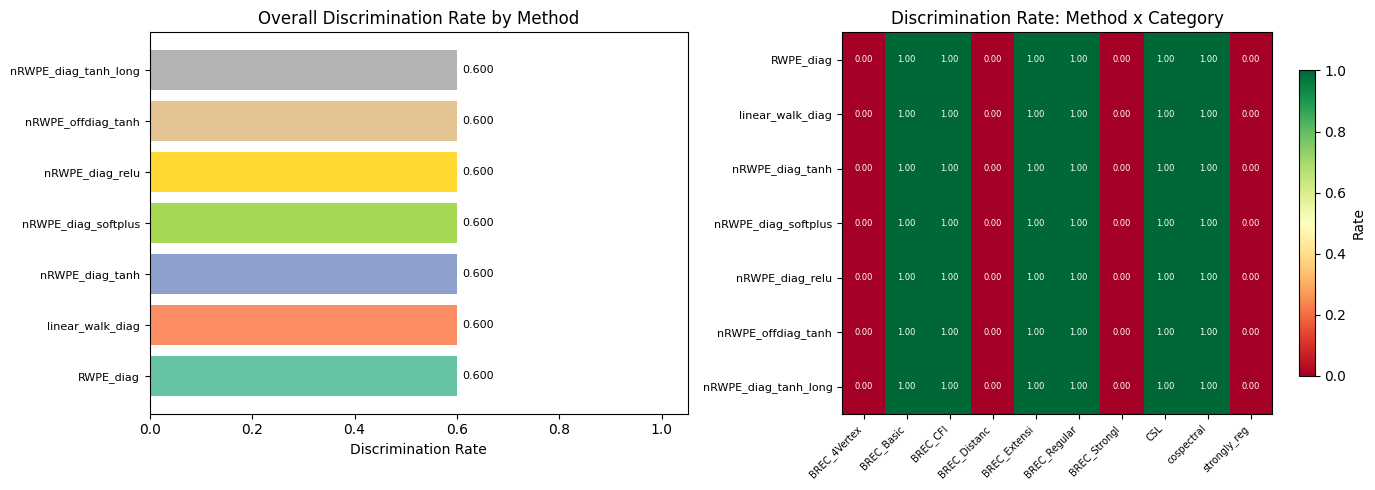

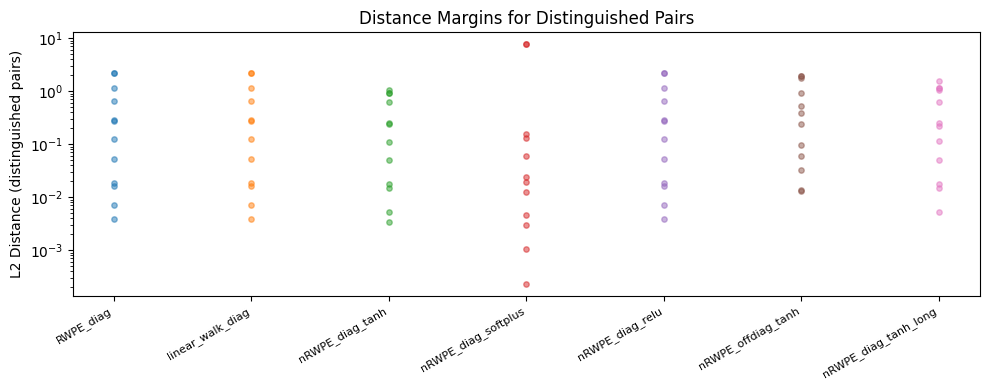

Done! All cells executed successfully.


In [13]:
methods_list = list(get_methods().keys())
cats_list = sorted(set(r['category'] for r in pair_results))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Overall rates bar chart
overall_rates = [per_method[m]['overall']['rate'] for m in methods_list]
colors = plt.cm.Set2(np.linspace(0, 1, len(methods_list)))
bars = axes[0].barh(range(len(methods_list)), overall_rates, color=colors)
axes[0].set_yticks(range(len(methods_list)))
axes[0].set_yticklabels(methods_list, fontsize=8)
axes[0].set_xlabel('Discrimination Rate')
axes[0].set_title('Overall Discrimination Rate by Method')
axes[0].set_xlim(0, 1.05)
for i, (bar, rate) in enumerate(zip(bars, overall_rates)):
    axes[0].text(rate + 0.01, i, f'{rate:.3f}', va='center', fontsize=8)

# Right: Per-category heatmap
rm = np.zeros((len(methods_list), len(cats_list)))
for i, m in enumerate(methods_list):
    for j, c in enumerate(cats_list):
        rm[i, j] = per_method[m]['per_category'][c]['rate']
im = axes[1].imshow(rm, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_xticks(range(len(cats_list)))
axes[1].set_xticklabels([c[:12] for c in cats_list], rotation=45, ha='right', fontsize=7)
axes[1].set_yticks(range(len(methods_list)))
axes[1].set_yticklabels(methods_list, fontsize=8)
axes[1].set_title('Discrimination Rate: Method x Category')
plt.colorbar(im, ax=axes[1], shrink=0.8, label='Rate')
for i in range(len(methods_list)):
    for j in range(len(cats_list)):
        v = rm[i, j]
        axes[1].text(j, i, f'{v:.2f}', ha='center', va='center',
                     fontsize=6, color='black' if 0.3 < v < 0.7 else 'white')
plt.tight_layout()
plt.show()

# Distance scatter
fig2, ax2 = plt.subplots(figsize=(10, 4))
for idx, m in enumerate(methods_list):
    dists = [r['distances'][m] for r in pair_results if r['distinguished'][m]]
    if dists:
        ax2.scatter([idx] * len(dists), dists, alpha=0.5, s=15)
ax2.set_xticks(range(len(methods_list)))
ax2.set_xticklabels(methods_list, rotation=30, ha='right', fontsize=8)
ax2.set_ylabel('L2 Distance (distinguished pairs)')
ax2.set_title('Distance Margins for Distinguished Pairs')
ax2.set_yscale('log')
plt.tight_layout()
plt.show()
print('Done! All cells executed successfully.')